In [2]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertModel
import torch

/Users/danielcoker/Documents/School/500 Level/Final Year Project/Emergency Management System/Code Playground/SVM  Playground/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from descriptions import descriptions

category_names = {0: "Fire", 1: "Crime", 2: "Health"}

for key, item in descriptions.items():
    print(key, len(item))

data = {
    "Description": [],
    "IncidentCategory": []
}

print("====================")

for key, item in descriptions.items():
    _item_list = list(set(item))
    data["Description"] += _item_list

    print(key, len(_item_list))

    if key == "fire":
        category_key = 0
    elif key == "crime":
        category_key = 1
    elif key == "health":
        category_key = 2
    else:
        raise Exception("Invalid key")

    data["IncidentCategory"] += [category_key for _ in range(len(_item_list))]

health 169
fire 143
crime 143
health 154
fire 123
crime 100


In [4]:
import string

def remove_punctuation(input_string):
    # Make a translation table that maps all punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Apply the translation table to the input string
    result = input_string.translate(translator)

    return result

In [5]:
df = pd.DataFrame(data)

In [6]:
df

,Description,IncidentCategory
0,"In the music room, a student experiences a sud...",2
1,"In the parking lot, a student has a visible in...",2
2,"Near the courtyard, a student has a severe ast...",2
3,"In the music room, a student collapses while p...",2
4,Witnessing a sudden collapse near the staircas...,2
...,...,...
372,Windows were smashed and lights broken in the ...,1
373,A student reports their bicycle stolen from th...,1
374,A student is found in possession of a fake ID ...,1
375,"In the language lab, a student's personal belo...",1


In [7]:
# Apply remove_punctuation function
df['Description'] = df['Description'].apply(remove_punctuation)

# Lowercase
df['Description'] = df['Description'].str.lower()

# Tokenization
df['Description'] = df['Description'].apply(nltk.word_tokenize)

# Stop Word Removal
stop_words = set(stopwords.words('english'))
df['Description'] = df['Description'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Stemming
stemmer = PorterStemmer()
df['Description'] = df['Description'].apply(lambda tokens: [stemmer.stem(word) for word in tokens])

# Join the tokens back into a single string
df['Description'] = df['Description'].apply(' '.join)

# BERT Tokenization and Embeddings
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [8]:
df

,Description,IncidentCategory
0,music room student experi sudden loss hear nee...,2
1,park lot student visibl injuri bicycl accid pa...,2
2,near courtyard student sever asthma attack str...,2
3,music room student collaps play instrument oth...,2
4,wit sudden collaps near staircas swiftli reach...,2
...,...,...
372,window smash light broken scienc lab disrupt r...,1
373,student report bicycl stolen design bike rack ...,1
374,student found possess fake id purchas alcohol ...,1
375,languag lab student person belong stolen step ...,1


In [9]:
# BERT Tokenization and Embeddings
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [11]:
# Function to get BERT embeddings for a sentence
def get_bert_embeddings(sentence):
    inputs = tokenizer(sentence, return_tensors="pt")
    outputs = model(**inputs)

    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

In [12]:
# Apply BERT embeddings to each description
df['BERT_Embeddings'] = df['Description'].apply(get_bert_embeddings)


In [13]:
df

,Description,IncidentCategory,BERT_Embeddings
0,music room student experi sudden loss hear nee...,2,"[-0.23163998, -0.098914996, 0.25339624, -0.139..."
1,park lot student visibl injuri bicycl accid pa...,2,"[-0.3566947, -0.17160292, 0.2157207, -0.034758..."
2,near courtyard student sever asthma attack str...,2,"[-0.13961504, -0.057183165, 0.16805217, -0.109..."
3,music room student collaps play instrument oth...,2,"[-0.09505111, 0.0941174, 0.10713117, 0.0540356..."
4,wit sudden collaps near staircas swiftli reach...,2,"[-0.08076562, -0.116519704, 0.39409757, 0.0865..."
...,...,...,...
372,window smash light broken scienc lab disrupt r...,1,"[-0.023343408, -0.054696966, 0.23567699, 0.033..."
373,student report bicycl stolen design bike rack ...,1,"[0.28438836, -0.11949191, 0.07881497, 0.000545..."
374,student found possess fake id purchas alcohol ...,1,"[0.09401407, 0.020361401, 0.17949253, -0.11307..."
375,languag lab student person belong stolen step ...,1,"[-0.07886325, -0.16359966, 0.019625388, -0.128..."


In [14]:
# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df['BERT_Embeddings'].tolist(),
    df['IncidentCategory'],
    test_size=0.2,
    random_state=42,
)

In [15]:
# Train the SVM Model
svm_classifier = SVC(kernel='linear', C=0.5, random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(C=0.5, kernel='linear', random_state=42)

In [16]:
# Make predictions on the test set
svm_predictions = svm_classifier.predict(X_test)

In [17]:
# Evaluate the model
report = classification_report(y_test, svm_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        18
           1       1.00      0.84      0.91        19
           2       0.95      1.00      0.97        39

    accuracy                           0.96        76
   macro avg       0.97      0.95      0.95        76
weighted avg       0.96      0.96      0.96        76



In [18]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, svm_predictions)

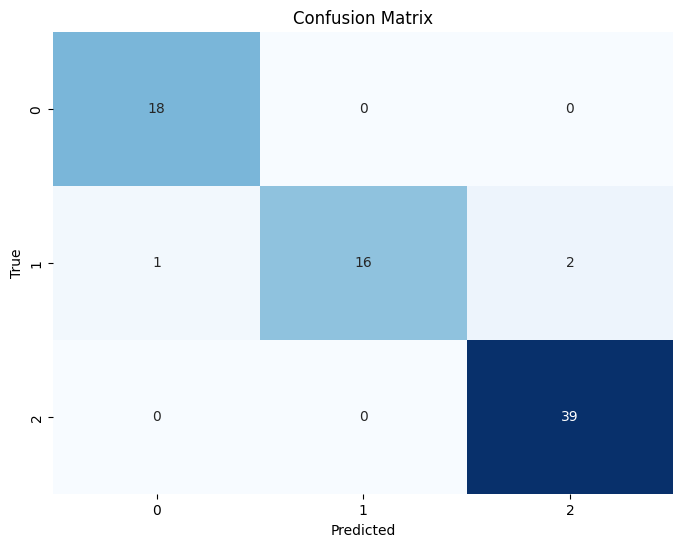

In [19]:
# category_names = {0: "Fire", 1: "Crime", 2: "Health"}

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=svm_classifier.classes_, yticklabels=svm_classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [20]:
# Function to get BERT embeddings for user input
def get_user_input_embeddings(user_input):
    user_input_processed = remove_punctuation(user_input.lower())
    user_input_tokens = nltk.word_tokenize(user_input_processed)
    user_input_tokens = [word for word in user_input_tokens if word not in stop_words]
    user_input_tokens = [stemmer.stem(word) for word in user_input_tokens]
    user_input_string = ' '.join(user_input_tokens)
    user_input_embedding = get_bert_embeddings(user_input_string)

    return user_input_embedding

In [40]:
# Test Input

"""
Fire broke out in the lab
A student is running dubs at T.I Francis, send the sheriffs
Accident happened at engineering building abeg.
I fell from the stairs while cleaning now I can't feel my legs, help!!
"""


user_input = "Accident happened at engineering building abeg"

# Get BERT embeddings for user input
user_input_embedding = get_user_input_embeddings(user_input)

# Make prediction using the trained SVM model
user_prediction = svm_classifier.predict([user_input_embedding])

print(user_prediction)

predicted_category_name = category_names[user_prediction[0]]

# Display the prediction
print(
    "Predicted Incident Category:",
    f"{predicted_category_name} ({user_prediction[0]})",
)

[2]
Predicted Incident Category: Health (2)
